### OpenCV DNN 패키지를 이용하여 Faster R-CNN 기반의 Object Detection 수행
* Tensorflow 에서 Pretrained 된 모델 파일을 OpenCV에서 로드하여 이미지와 영상에 대한 Object Detection 수행.

### 필요한 패키지 설치

In [1]:
!pip install tqdm
# !pip install opencv-python
# !pip install opencv-contrib-python

#### Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
* https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
* pretrained 모델은 http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz 에서 다운로드 후 압축 해제
* pretrained 모델을 위한 환경 파일은 https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt 에서 다운로드
* download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함.


In [2]:
!mkdir ./pretrained
!wget -O ./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
!wget -O ./pretrained/config_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt

--2023-10-18 08:03:04--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.207, 74.125.195.207, 172.253.117.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

./pretrained/faster 100%[===================>] 363.69M   173MB/s    in 2.1s    

2023-10-18 08:03:06 (173 MB/s) - ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]

--2023-10-18 08:03:06--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubuserconten

In [3]:
!tar -xvf ./pretrained/faster*.tar.gz -C ./pretrained

faster_rcnn_resnet50_coco_2018_01_28/
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet50_coco_2018_01_28/checkpoint
faster_rcnn_resnet50_coco_2018_01_28/pipeline.config
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.meta
faster_rcnn_resnet50_coco_2018_01_28/saved_model/
faster_rcnn_resnet50_coco_2018_01_28/saved_model/saved_model.pb
faster_rcnn_resnet50_coco_2018_01_28/saved_model/variables/
faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb


In [4]:
!pwd
!ls -lia ./pretrained/faster_rcnn_resnet50_coco_2018_01_28

/content
total 296076
1310847 drwxr-xr-x 3 345018 5000      4096 Feb  1  2018 .
1310843 drwxr-xr-x 3 root   root      4096 Oct 18 08:03 ..
1310849 -rw-r--r-- 1 345018 5000        77 Feb  1  2018 checkpoint
1310856 -rw-r--r-- 1 345018 5000 120549957 Feb  1  2018 frozen_inference_graph.pb
1310851 -rw-r--r-- 1 345018 5000 176914228 Feb  1  2018 model.ckpt.data-00000-of-00001
1310848 -rw-r--r-- 1 345018 5000     14460 Feb  1  2018 model.ckpt.index
1310852 -rw-r--r-- 1 345018 5000   5675175 Feb  1  2018 model.ckpt.meta
1310850 -rw-r--r-- 1 345018 5000      3240 Feb  1  2018 pipeline.config
1310853 drwxr-xr-x 3 345018 5000      4096 Feb  1  2018 saved_model


#### dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [5]:
import cv2
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb',
                                     './pretrained/config_graph.pbtxt')

#### coco 데이터 세트의 클래스id별 클래스명 지정.

In [6]:
# OpenCV Tensorflow Faster-RCNN용
labels_to_names_0 = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

#### 이미지를 preprocessing 수행하여 Network에 입력하고 Object Detection 수행 후 결과를 이미지에 시각화

In [7]:
!mkdir data
!cd data
!wget https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/3_day/4.opencv_faster_rcnn/data/sample1.jpg
!wget https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/3_day/4.opencv_faster_rcnn/data/sample2.jpg
!wget https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/3_day/4.opencv_faster_rcnn/data/ant.mp4

--2023-10-18 08:05:06--  https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/3_day/4.opencv_faster_rcnn/data/sample1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117627 (115K) [image/jpeg]
Saving to: ‘sample1.jpg’

sample1.jpg         100%[===================>] 114.87K  --.-KB/s    in 0.02s   

2023-10-18 08:05:06 (6.07 MB/s) - ‘sample1.jpg’ saved [117627/117627]

--2023-10-18 08:05:06--  https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/3_day/4.opencv_faster_rcnn/data/sample2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting re

image shape: (427, 640, 3)


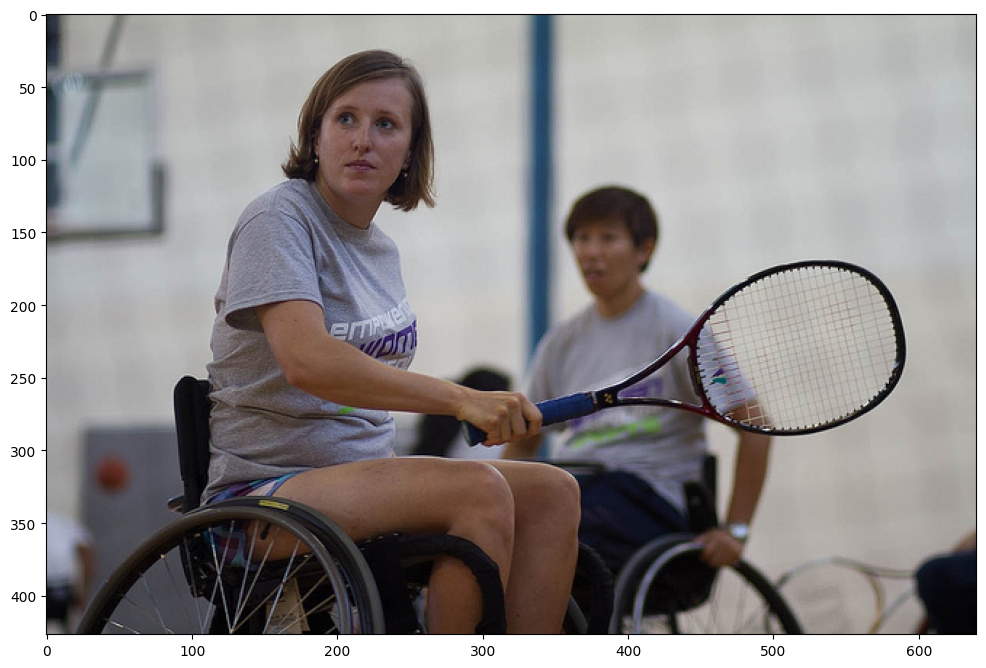

In [8]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./data/sample1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()

(1, 1, 100, 7)
person: 0.9951
tennis racket: 0.9943
person: 0.6901
bicycle: 0.6701
tennis racket: 0.5629


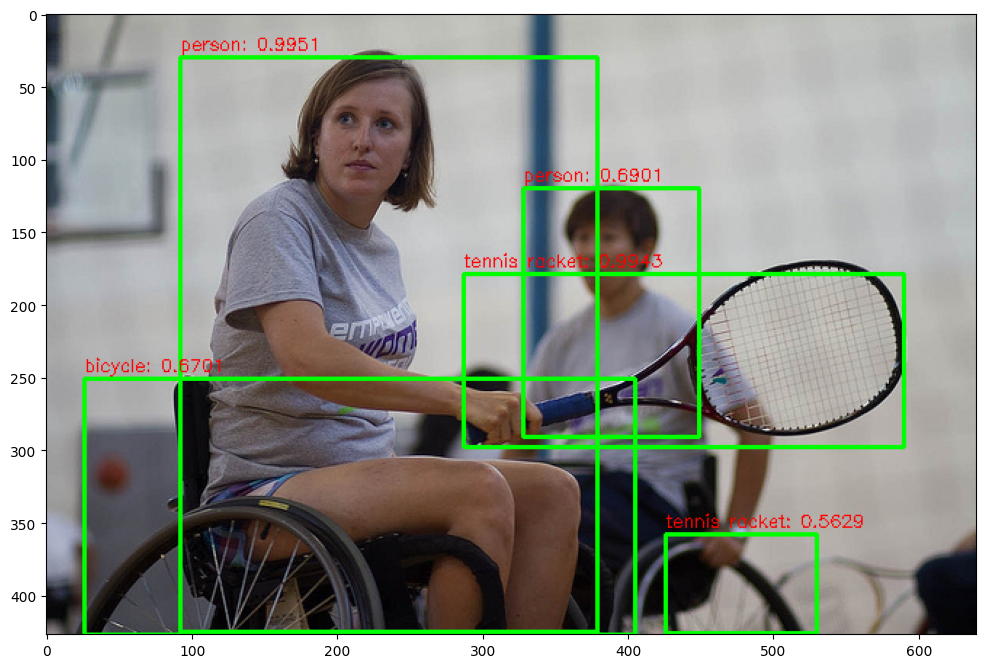

In [9]:
# 원본 이미지가 Faster RCNN기반 네트웍으로 입력 시 resize됨.
# scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성.
draw_img = img.copy()

# 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력. Tensorflow Faster RCNN은 마지막 classification layer가 Dense가 아니여서 size를 고정할 필요는 없음.
cv_net.setInput(cv2.dnn.blobFromImage(img, swapRB=True, crop=False))

# Object Detection 수행하여 결과를 cvOut으로 반환
cv_out = cv_net.forward()
print(cv_out.shape)

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# detected 된 object들을 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:
    score = float(detection[2])
    class_id = int(detection[1])
    # detected된 object들의 score가 0.5 이상만 추출
    if score > 0.5:
        # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
        # labels_to_names_seq 딕셔너리로 class_id값을 클래스명으로 변경.
        caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
        print(caption)
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()

#### 단일 이미지의 object detection을 함수로 생성

In [10]:
import time

def get_detected_img(cv_net, img_array, score_threshold, use_copied_array=True, is_print=True):

    rows = img_array.shape[0]
    cols = img_array.shape[1]

    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array

    cv_net.setInput(cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False))

    start = time.time()
    cv_out = cv_net.forward()

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)

    # detected 된 object들을 iteration 하면서 정보 추출
    for detection in cv_out[0,0,:,:]:
        score = float(detection[2])
        class_id = int(detection[1])
        # detected된 object들의 score가 함수 인자로 들어온 score_threshold 이상만 추출
        if score > score_threshold:
            # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows
            # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
            caption = "{}: {:.4f}".format(labels_to_names_0[class_id], score)
            # print(caption)
            #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
            cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
            cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
    if is_print:
        print('Detection 수행시간:',round(time.time() - start, 2),"초")

    return draw_img

image shape: (427, 640, 3)
Detection 수행시간: 8.36 초


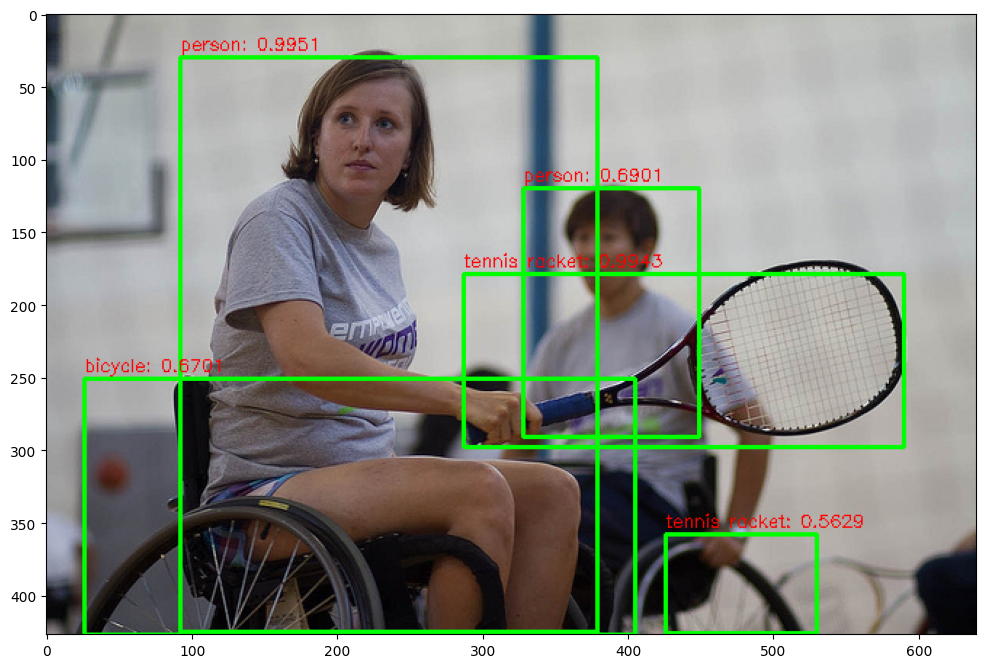

In [11]:
# image 로드
img = cv2.imread('./data/sample1.jpg')
print('image shape:', img.shape)

# tensorflow inference 모델 로딩
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb',
                                     './pretrained/config_graph.pbtxt')
# Object Detetion 수행 후 시각화
draw_img = get_detected_img(cv_net, img, score_threshold=0.5, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()

image shape: (640, 639, 3)
Detection 수행시간: 5.22 초


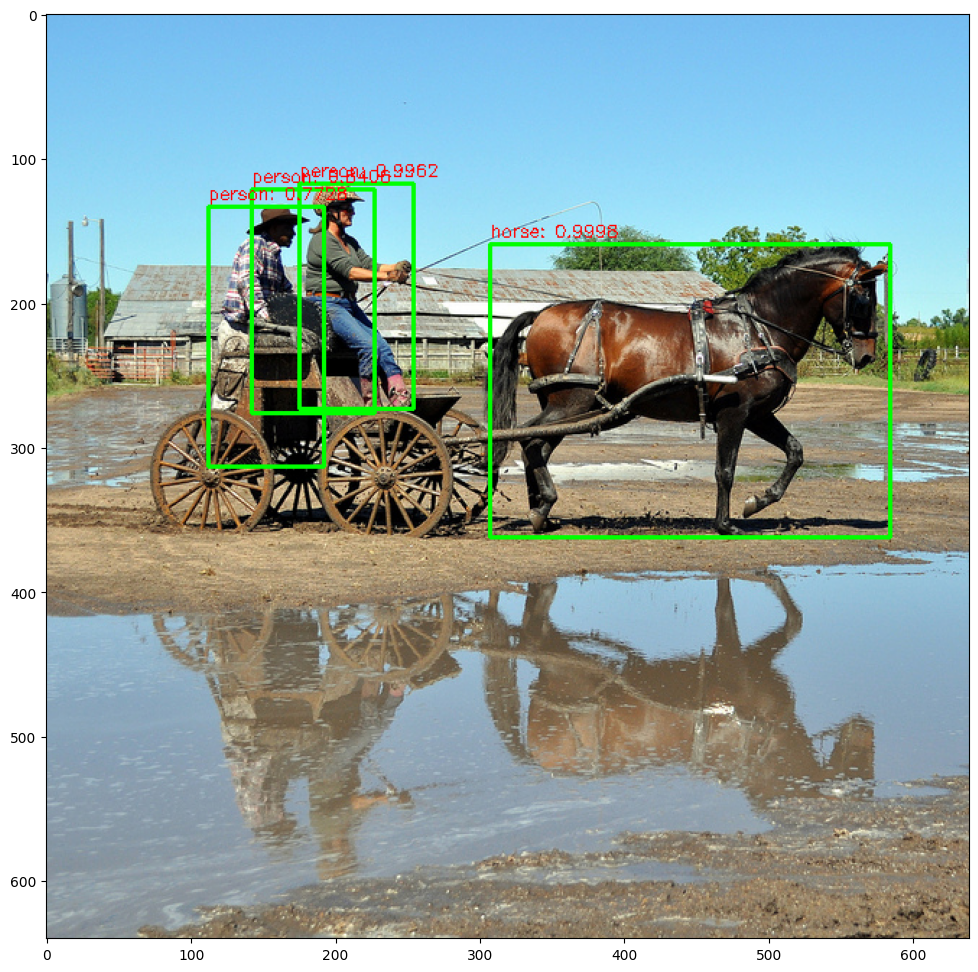

In [12]:
img = cv2.imread('./data/sample2.jpg')
print('image shape:', img.shape)

# tensorflow inference 모델 로딩
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb',
                                     './pretrained/config_graph.pbtxt')
# Object Detetion 수행 후 시각화
draw_img = get_detected_img(cv_net, img, score_threshold=0.5, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()

### Video Object Detection 수행

#### VideoCapture와 VideoWriter 설정하기
* VideoCapture를 이용하여 Video를 frame별로 capture 할 수 있도록 설정
* VideoCapture의 속성을 이용하여 Video Frame의 크기 및 FPS 설정.
* VideoWriter를 위한 인코딩 코덱 설정 및 영상 write를 위한 설정

#### video detection 적용 후 재생 함수 생성.

In [13]:
import IPython.display as display
from PIL import Image

def do_detected_play(cv_net, input_path, score_threshold, is_print):

    cap = cv2.VideoCapture(input_path)
    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        img_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, use_copied_array=False, is_print=is_print)
        clone = img_frame.copy()
        clone = cv2.cvtColor(clone, cv2.COLOR_BGR2RGB)
        display.clear_output(wait=True)
        display.display(Image.fromarray(clone))

    cap.release()

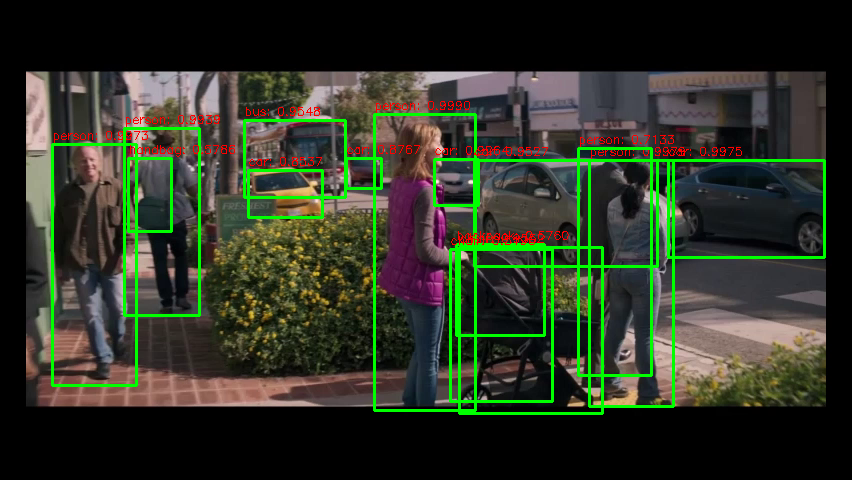

KeyboardInterrupt: ignored

In [14]:
do_detected_play(cv_net, './data/ant.mp4', 0.5, False)

### 동영상 파일로 저장 후 재생 하기

In [ ]:
# !apt update
# !apt install -y build-essential cmake git python3-dev python3-numpy \
# libavcodec-dev libavformat-dev libswscale-dev \
# libgstreamer-plugins-base1.0-dev \
# libgstreamer1.0-dev libgtk-3-dev \
# libpng-dev libjpeg-dev libopenexr-dev libtiff-dev libwebp-dev \
# libopencv-dev x264 libx264-dev libssl-dev ffmpeg
# !pip uninstall -y opencv-python
# avc1 코덱을 사용하려면 binary 버전의 opencv-python을 삭제하고 소스로 다시 설치 해야함
# !pip install --no-binary opencv-python opencv-python
# 커널 재시작 해야 함

In [15]:
from tqdm import notebook

def do_detected_video(cv_net, input_path, output_path, score_threshold, is_print):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    for i in notebook.tqdm(range(frame_cnt)):
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        img_frame = get_detected_img(cv_net, img_frame, score_threshold=score_threshold, use_copied_array=False, is_print=is_print)
        vid_writer.write(img_frame)

    vid_writer.release()
    cap.release()

In [16]:
do_detected_video(cv_net, './data/ant.mp4', './data/ant_detected.mp4', 0.5, False)

총 Frame 갯수: 300


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
# from IPython.display import Video

# Video("./data/ant_detected.mp4")